In [135]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from keras.regularizers import l2


from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
from scikeras.wrappers import KerasClassifier
from sklearn import metrics

import numpy as np
import pandas as pd
from preprocessing import *
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(123)
tf.random.set_seed(123)

In [21]:
SCORINGS = ["roc_auc", "accuracy", "precision", "recall", "f1"]
METRIC = "roc_auc"

def metrics_table(model, X, Y):
    predicted = model.predict(X)
    probabilities = model.predict_proba(X)[:,1]
    
    roc_auc = metrics.roc_auc_score(Y, probabilities)
    f1 = metrics.f1_score(Y, predicted)
    acc = metrics.accuracy_score(Y, predicted)
    rec = metrics.recall_score(Y, predicted)
    prec = metrics.precision_score(Y, predicted)
    return pd.DataFrame.from_dict({
        "AUC-ROC": [roc_auc], "Accuracy": [acc], "Precision": [prec], "Recall": [rec], "F1 Score": [f1]
    })

def plot_rmse(history):
    loss = np.sqrt(history["loss"])
    val_loss = np.sqrt(history["val_loss"])
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")

# Modelo inicial (Adam)

In [4]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [5]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [46]:
model = Sequential()
model.add(Dense(100, input_shape = (len(X_train.columns),), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

NameError: name 'Adam' is not defined

In [7]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [8]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fd9ca878070>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7fd9ca878a30>, verbose=0)]])

In [9]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 261


Text(0.5, 0, 'Época')

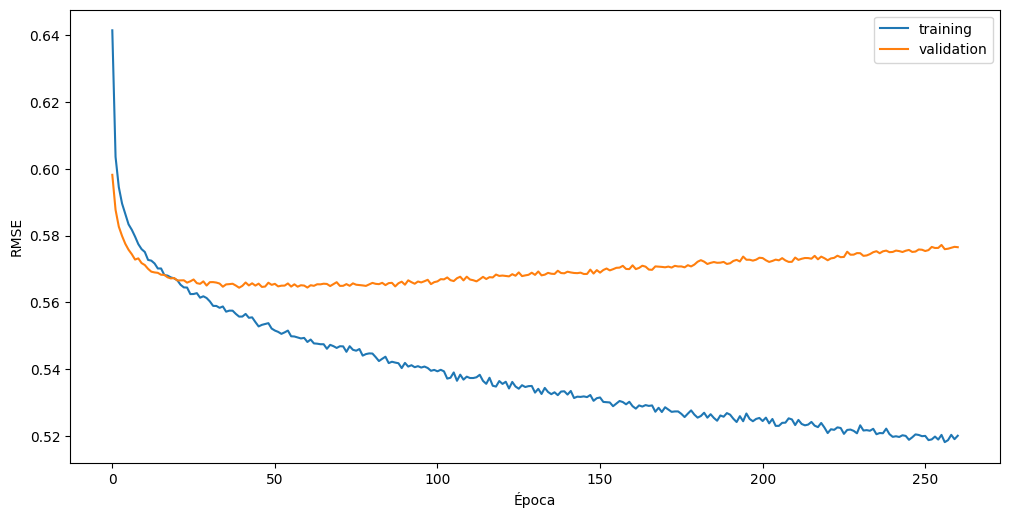

In [10]:
plot_rmse(history)

In [11]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.896892,0.864094,0.761754,0.571767,0.653227


En el gráfico se puede ver que claramente overfitteo, pero aún así dio valores de AUC-ROC aceptables (0.897). Podemos intentar aplicar una regularización, y achicar un poco la arquitectura. El learning rate parece tener un valor correcto.

# Regularización y Adam

In [94]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [95]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [96]:
model = Sequential()
model.add(Dense(20, input_shape = (len(X_train.columns),), activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(10, activation="sigmoid", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 20)                960       
                                                                 
 dropout_24 (Dropout)        (None, 20)                0         
                                                                 
 dense_37 (Dense)            (None, 10)                210       
                                                                 
 dropout_25 (Dropout)        (None, 10)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,181
Trainable params: 1,181
Non-trainable params: 0
_________________________________________________________________


In [97]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [98]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fd9c8a92340>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7fd9c8a79250>, verbose=0)]])

In [99]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 744


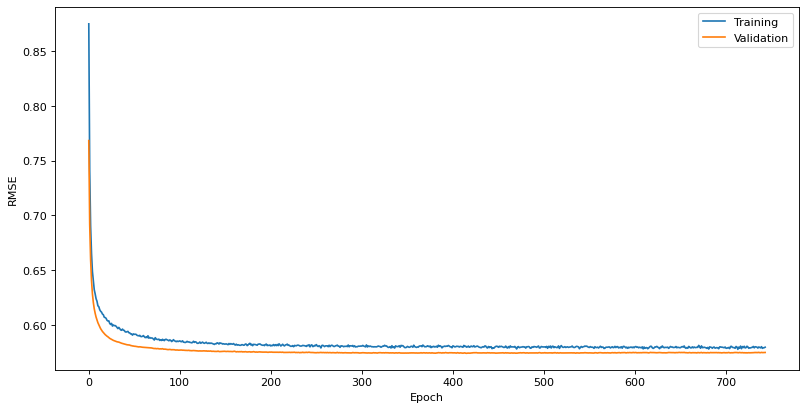

In [100]:
plot_rmse(history)

In [101]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.892427,0.859683,0.775142,0.525751,0.626542


Overfitteo bastante menos, pero el AUC-ROC empeoró. Vamos a probar con otro optimizador

# Regularización y SGD

In [110]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [111]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [112]:
model = Sequential()
model.add(Dense(20, input_shape = (len(X_train.columns),), activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(10, activation="sigmoid", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(learning_rate=0.001, momentum = 0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 20)                960       
                                                                 
 dropout_28 (Dropout)        (None, 20)                0         
                                                                 
 dense_43 (Dense)            (None, 10)                210       
                                                                 
 dropout_29 (Dropout)        (None, 10)                0         
                                                                 
 dense_44 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,181
Trainable params: 1,181
Non-trainable params: 0
_________________________________________________________________


In [113]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [114]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fd9c81c1d30>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7fd9c81beb80>, verbose=0)]])

In [115]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 3000


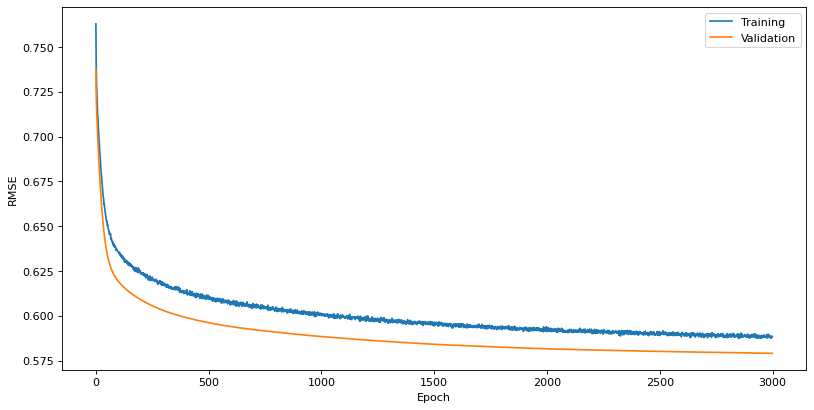

In [116]:
plot_rmse(history)

In [117]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.887477,0.857059,0.743246,0.552313,0.63371


Dio un poco peor, vamos a probar con otro distinto.

# Regularización y Adadelta

In [136]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [137]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [138]:
model = Sequential()
model.add(Dense(20, input_shape = (len(X_train.columns),), activation='relu', kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(10, activation="sigmoid", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = Adadelta(learning_rate = 1.0) # Es el inicial, luego se ajusta solo
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 20)                960       
                                                                 
 dropout_34 (Dropout)        (None, 20)                0         
                                                                 
 dense_52 (Dense)            (None, 10)                210       
                                                                 
 dropout_35 (Dropout)        (None, 10)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,181
Trainable params: 1,181
Non-trainable params: 0
_________________________________________________________________


In [139]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [140]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fd9c7933580>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7fd9c79497f0>, verbose=0)]])

In [141]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 1145


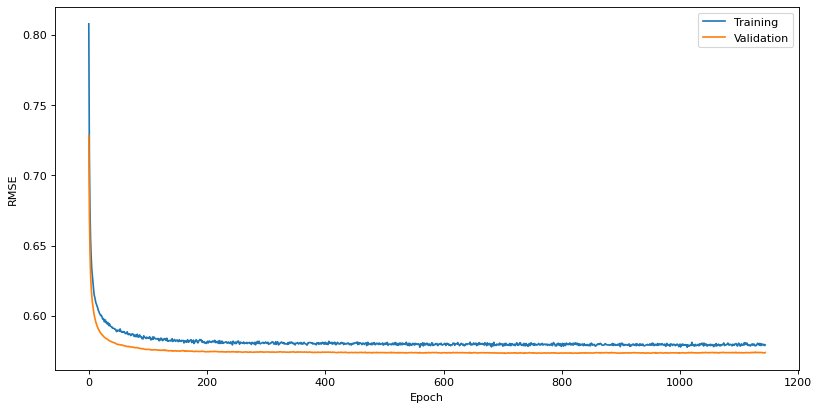

In [142]:
plot_rmse(history)

In [143]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.893204,0.859293,0.767944,0.532361,0.628811


Este dio bastante mejor, comparado a los otros regularizados. Por últimos vamos a probar a cambiar un poco más la estructura de la red.

# Regularización y Adadelta v2, más profundo

In [177]:
df_features, df_target = get_datasets()

viento_trigonometrico(df_features)
df_features = hashing_trick(df_features, 24, "barrio")

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.35, random_state=123)

pipe = iterative_imputer()
pipe = standarizer(pipe)
len(X_train.columns)

47

In [178]:
pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

In [179]:
model = Sequential()
model.add(Dense(20, input_shape = (len(X_train.columns),), activation='relu', kernel_regularizer=l2(0.00001)))
model.add(Dropout(0.2))
model.add(Dense(8, input_shape = (len(X_train.columns),), activation='sigmoid', kernel_regularizer=l2(0.00001)))
model.add(Dropout(0.2))
model.add(Dense(8, activation="tanh", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(4, activation="tanh", kernel_regularizer=l2(0.00005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = Adadelta(learning_rate = 1.0) # Es el inicial, luego se ajusta solo
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 20)                960       
                                                                 
 dropout_54 (Dropout)        (None, 20)                0         
                                                                 
 dense_78 (Dense)            (None, 8)                 168       
                                                                 
 dropout_55 (Dropout)        (None, 8)                 0         
                                                                 
 dense_79 (Dense)            (None, 8)                 72        
                                                                 
 dropout_56 (Dropout)        (None, 8)                 0         
                                                                 
 dense_80 (Dense)            (None, 4)               

In [180]:
early_stop = EarlyStopping(monitor = "val_auc", mode = "max", patience = 200, restore_best_weights = True)

pipe.steps.append(['keras', KerasClassifier(model, batch_size = 1000, epochs = 3000, callbacks = [early_stop],
                                           verbose = 0)])

In [181]:
pipe.fit(X_train, Y_train, keras__validation_data=(X_test_mod, Y_test))

Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                ('scaler', StandardScaler()),
                ['keras',
                 KerasClassifier(batch_size=1000, callbacks=[<keras.callbacks.EarlyStopping object at 0x7fd9c6791c70>], epochs=3000, model=<keras.engine.sequential.Sequential object at 0x7fd9c6806c10>, verbose=0)]])

In [182]:
history = pipe.named_steps['keras'].history_
print(f"Cantidad de epochs procesadas: {len(history['loss'])}")

Cantidad de epochs procesadas: 1257


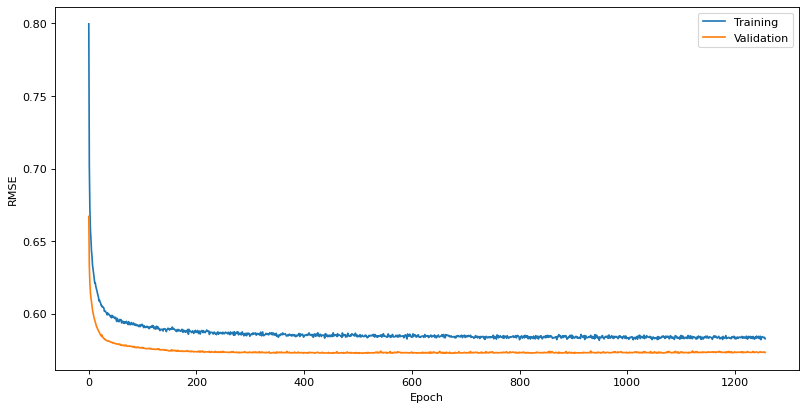

In [183]:
plot_rmse(history)

In [184]:
metrics_table(pipe, X_test, Y_test)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.892545,0.858734,0.756457,0.544208,0.633014


Dio un poco peor que el anterior en cuanto a AUC-ROC.